# 텍스트마이닝 예측과 LDA 모델

In [46]:
pwd

'd:\\자료\\text mining'

In [43]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import pandas as pd
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import warnings
warnings.filterwarnings(action='ignore') 

https://wikidocs.net/30708

The previous sections outline the fundamental ideas of machine learning, but all of the examples assume that you have numerical data in a tidy, ``[n_samples, n_features]`` format.
In the real world, data rarely comes in such a form.
With this in mind, one of the more important steps in using machine learning in practice is *feature engineering*: that is, taking whatever information you have about your problem and turning it into numbers that you can use to build your feature matrix.

In this section, we will cover a few common examples of feature engineering tasks: features for representing *categorical data*, features for representing *text*, and features for representing *images*.
Additionally, we will discuss *derived features* for increasing model complexity and *imputation* of missing data.
Often this process is known as *vectorization*, as it involves converting arbitrary data into well-behaved vectors.

## Categorical Features

One common type of non-numerical data is *categorical* data.
For example, imagine you are exploring some data on housing prices, and along with numerical features like "price" and "rooms", you also have "neighborhood" information.
For example, your data might look something like this:

In [3]:
data = [
    {'price': 850000, 'rooms': 4, 'neighborhood': 'Queen Anne'},
    {'price': 700000, 'rooms': 3, 'neighborhood': 'Fremont'},
    {'price': 650000, 'rooms': 3, 'neighborhood': 'Wallingford'},
    {'price': 600000, 'rooms': 2, 'neighborhood': 'Fremont'}
]
data
pd.DataFrame(data)

[{'price': 850000, 'rooms': 4, 'neighborhood': 'Queen Anne'},
 {'price': 700000, 'rooms': 3, 'neighborhood': 'Fremont'},
 {'price': 650000, 'rooms': 3, 'neighborhood': 'Wallingford'},
 {'price': 600000, 'rooms': 2, 'neighborhood': 'Fremont'}]

,neighborhood,price,rooms
0,Queen Anne,850000,4
1,Fremont,700000,3
2,Wallingford,650000,3
3,Fremont,600000,2


You might be tempted to encode this data with a straightforward numerical mapping:

In [4]:
{'Queen Anne': 1, 'Fremont': 2, 'Wallingford': 3};

It turns out that this is not generally a useful approach in Scikit-Learn: the package's models make the fundamental assumption that numerical features reflect algebraic quantities.
Thus such a mapping would imply, for example, that *Queen Anne < Fremont < Wallingford*, or even that *Wallingford - Queen Anne = Fremont*, which (niche demographic jokes aside) does not make much sense.

In this case, one proven technique is to use *one-hot encoding*, which effectively creates extra columns indicating the presence or absence of a category with a value of 1 or 0, respectively.
When your data comes as a list of dictionaries, Scikit-Learn's ``DictVectorizer`` will do this for you:

In [5]:
pd.DataFrame(data).dtypes

neighborhood    object
price            int64
rooms            int64
dtype: object

In [6]:
from sklearn.feature_extraction import DictVectorizer
vec = DictVectorizer(sparse=False, dtype=int)
vec.fit_transform(data)

array([[     0,      1,      0, 850000,      4],
       [     1,      0,      0, 700000,      3],
       [     0,      0,      1, 650000,      3],
       [     1,      0,      0, 600000,      2]], dtype=int32)

Notice that the 'neighborhood' column has been expanded into three separate columns, representing the three neighborhood labels, and that each row has a 1 in the column associated with its neighborhood.
With these categorical features thus encoded, you can proceed as normal with fitting a Scikit-Learn model.

To see the meaning of each column, you can inspect the feature names:

In [7]:
vec.get_feature_names()

['neighborhood=Fremont',
 'neighborhood=Queen Anne',
 'neighborhood=Wallingford',
 'price',
 'rooms']

There is one clear disadvantage of this approach: if your category has many possible values, this can *greatly* increase the size of your dataset.
However, because the encoded data contains mostly zeros, a sparse output can be a very efficient solution:

In [8]:
vec = DictVectorizer(sparse=True, dtype=int)
vec.fit_transform(data)

<4x5 sparse matrix of type '<class 'numpy.int32'>'
	with 12 stored elements in Compressed Sparse Row format>

Many (though not yet all) of the Scikit-Learn estimators accept such sparse inputs when fitting and evaluating models. ``sklearn.preprocessing.OneHotEncoder`` and ``sklearn.feature_extraction.FeatureHasher`` are two additional tools that Scikit-Learn includes to support this type of encoding.

## Text Features

Another common need in feature engineering is to convert text to a set of representative numerical values.
For example, most automatic mining of social media data relies on some form of encoding the text as numbers.
One of the simplest methods of encoding data is by *word counts*: you take each snippet of text, count the occurrences of each word within it, and put the results in a table.

For example, consider the following set of three phrases:

In [9]:
sample_kor = ['아버지가 가방에 들어가신다.', '어머니는 시장에 가신다', '붙여쓰면모르지']

For a vectorization of this data based on word count, we could construct a column representing the word "problem," the word "evil," the word "horizon," and so on.
While doing this by hand would be possible, the tedium can be avoided by using Scikit-Learn's ``CountVectorizer``:

In [10]:
from sklearn.feature_extraction.text import CountVectorizer

vec = CountVectorizer()
X = vec.fit_transform(sample_kor)
X
pd.DataFrame(X.toarray(), columns=vec.get_feature_names())

<3x7 sparse matrix of type '<class 'numpy.int64'>'
	with 7 stored elements in Compressed Sparse Row format>

,가방에,가신다,들어가신다,붙여쓰면모르지,시장에,아버지가,어머니는
0,1,0,1,0,0,1,0
1,0,1,0,0,1,0,1
2,0,0,0,1,0,0,0


In [11]:
sample = ['problem of evil', 'evil queen', 'horizon problem']

In [12]:
from sklearn.feature_extraction.text import CountVectorizer

vec = CountVectorizer()
X = vec.fit_transform(sample)
X

<3x5 sparse matrix of type '<class 'numpy.int64'>'
	with 7 stored elements in Compressed Sparse Row format>

The result is a sparse matrix recording the number of times each word appears; it is easier to inspect if we convert this to a ``DataFrame`` with labeled columns:

In [13]:
pd.DataFrame(X.toarray(), columns=vec.get_feature_names())

,evil,horizon,of,problem,queen
0,1,0,1,1,0
1,1,0,0,0,1
2,0,1,0,1,0


There are some issues with this approach, however: the raw word counts lead to features which put too much weight on words that appear very frequently, and this can be sub-optimal in some classification algorithms.
One approach to fix this is known as *term frequency-inverse document frequency* (*TF–IDF*) which weights the word counts by a measure of how often they appear in the documents.
The syntax for computing these features is similar to the previous example:

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
vec = TfidfVectorizer()
X = vec.fit_transform(sample)
pd.DataFrame(X.toarray(), columns=vec.get_feature_names())

,evil,horizon,of,problem,queen
0,0.517856,0.000000,0.680919,0.517856,0.000000
1,0.605349,0.000000,0.000000,0.000000,0.795961
2,0.000000,0.795961,0.000000,0.605349,0.000000


For an example of using TF-IDF in a classification problem, see [In Depth: Naive Bayes Classification](05.05-Naive-Bayes.ipynb).

# Example: Classifying Text

One place where multinomial naive Bayes is often used is in text classification, where the features are related to word counts or frequencies within the documents to be classified.
We discussed the extraction of such features from text in [Feature Engineering](05.04-Feature-Engineering.ipynb); here we will use the sparse word count features from the 20 Newsgroups corpus to show how we might classify these short documents into categories.

Let's download the data and take a look at the target names:

In [12]:
from sklearn.datasets import fetch_20newsgroups

data = fetch_20newsgroups()
type(data)

sklearn.utils.Bunch

In [13]:
df = pd.DataFrame(data['data'], columns= ['content'])
df['target'] = pd.Series(data.target)
df.head()

,content,target
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,7
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,4
2,From: twillis@ec.ecn.purdue.edu (Thomas E Will...,4
3,From: jgreen@amber (Joe Green)\nSubject: Re: W...,1
4,From: jcm@head-cfa.harvard.edu (Jonathan McDow...,14


For simplicity here, we will select just a few of these categories, and download the training and testing set:

In [14]:
data.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

In [15]:
categories = ['talk.religion.misc', 'soc.religion.christian','sci.space', 'comp.graphics']
train = fetch_20newsgroups(subset='train', categories=categories)
test = fetch_20newsgroups(subset='test', categories=categories)

Here is a representative entry from the data:

In [16]:
print(train.data[5])

From: dmcgee@uluhe.soest.hawaii.edu (Don McGee)
Subject: Federal Hearing
Originator: dmcgee@uluhe
Organization: School of Ocean and Earth Science and Technology
Distribution: usa
Lines: 10


Fact or rumor....?  Madalyn Murray O'Hare an atheist who eliminated the
use of the bible reading and prayer in public schools 15 years ago is now
going to appear before the FCC with a petition to stop the reading of the
Gospel on the airways of America.  And she is also campaigning to remove
Christmas programs, songs, etc from the public schools.  If it is true
then mail to Federal Communications Commission 1919 H Street Washington DC
20054 expressing your opposition to her request.  Reference Petition number

2493.



In order to use this data for machine learning, we need to be able to convert the content of each string into a vector of numbers.
For this we will use the TF-IDF vectorizer (discussed in [Feature Engineering](05.04-Feature-Engineering.ipynb)), and create a pipeline that attaches it to a multinomial naive Bayes classifier:

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline

model = make_pipeline(TfidfVectorizer(), MultinomialNB())

With this pipeline, we can apply the model to the training data, and predict labels for the test data:

In [18]:
model.fit(train.data, train.target)
labels = model.predict(test.data)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('multinomialnb', MultinomialNB())])

Now that we have predicted the labels for the test data, we can evaluate them to learn about the performance of the estimator.
For example, here is the confusion matrix between the true and predicted labels for the test data:

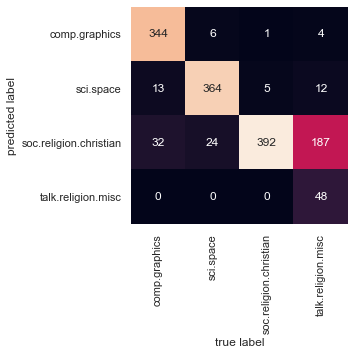

In [19]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(test.target, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=train.target_names, yticklabels=train.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

Evidently, even this very simple classifier can successfully separate space talk from computer talk, but it gets confused between talk about religion and talk about Christianity.
This is perhaps an expected area of confusion!

The very cool thing here is that we now have the tools to determine the category for *any* string, using the ``predict()`` method of this pipeline.
Here's a quick utility function that will return the prediction for a single string:

In [20]:
def predict_category(s, train=train, model=model):
    pred = model.predict([s])
    return train.target_names[pred[0]]

Let's try it out:

In [21]:
predict_category('sending a payload to the ISS')

'sci.space'

In [22]:
predict_category('discussing islam vs atheism')

'soc.religion.christian'

In [23]:
predict_category('determining the screen resolution')

'comp.graphics'

In [24]:
predict_category('scrip a code to run data')

'comp.graphics'

Remember that this is nothing more sophisticated than a simple probability model for the (weighted) frequency of each word in the string; nevertheless, the result is striking.
Even a very naive algorithm, when used carefully and trained on a large set of high-dimensional data, can be surprisingly effective.

# Example LDA

LDA는 문서의 집합으로부터 어떤 토픽이 존재하는지를 알아내기 위한 알고리즘입니다. LDA는 앞서 배운 빈도수 기반의 표현 방법인 BoW의 행렬 DTM 또는 TF-IDF 행렬을 입력으로 하는데, 이로부터 알 수 있는 사실은 LDA는 단어의 순서는 신경쓰지 않겠다는 겁니다.

LDA는 문서들로부터 토픽을 뽑아내기 위해서 이러한 가정을 염두해두고 있습니다. 모든 문서 하나, 하나가 작성될 때 그 문서의 작성자는 이러한 생각을 했습니다. '나는 이 문서를 작성하기 위해서 이런 주제들을 넣을거고, 이런 주제들을 위해서는 이런 단어들을 넣을 거야.' 조금 더 구체적으로 알아보겠습니다. 각각의 문서는 다음과 같은 과정을 거쳐서 작성되었다고 가정합니다.

### 1) 문서에 사용할 단어의 개수 N을 정합니다.
- Ex) 5개의 단어를 정하였습니다.
### 2) 문서에 사용할 토픽의 혼합을 확률 분포에 기반하여 결정합니다.
- Ex) 위 예제와 같이 토픽이 2개라고 하였을 때 강아지 토픽을 60%, 과일 토픽을 40%와 같이 선택할 수 있습니다.
### 3) 문서에 사용할 각 단어를 (아래와 같이) 정합니다.
#### 3-1) 토픽 분포에서 토픽 T를 확률적으로 고릅니다.
- Ex) 60% 확률로 강아지 토픽을 선택하고, 40% 확률로 과일 토픽을 선택할 수 있습니다.
####  3-2) 선택한 토픽 T에서 단어의 출현 확률 분포에 기반해 문서에 사용할 단어를 고릅니다.
- Ex) 강아지 토픽을 선택하였다면, 33% 확률로 강아지란 단어를 선택할 수 있습니다. 이제 3)을 반복하면서 문서를 완성합니다.

이러한 과정을 통해 문서가 작성되었다는 가정 하에 LDA는 토픽을 뽑아내기 위하여 위 과정을 역으로 추적하는 역공학(reverse engneering)을 수행합니다.

### 1. 데이터 불러오기

In [25]:
dataset = fetch_20newsgroups(shuffle=True, random_state=1, remove=('headers', 'footers', 'quotes'))
documents = dataset.data
len(documents)

11314

In [26]:
documents[0:2]

["Well i'm not sure about the story nad it did seem biased. What\nI disagree with is your statement that the U.S. Media is out to\nruin Israels reputation. That is rediculous. The U.S. media is\nthe most pro-israeli media in the world. Having lived in Europe\nI realize that incidences such as the one described in the\nletter have occured. The U.S. media as a whole seem to try to\nignore them. The U.S. is subsidizing Israels existance and the\nEuropeans are not (at least not to the same degree). So I think\nthat might be a reason they report more clearly on the\natrocities.\n\tWhat is a shame is that in Austria, daily reports of\nthe inhuman acts commited by Israeli soldiers and the blessing\nreceived from the Government makes some of the Holocaust guilt\ngo away. After all, look how the Jews are treating other races\nwhen they got power. It is unfortunate.\n",
 "\n\n\n\n\n\n\nYeah, do you expect people to read the FAQ, etc. and actually accept hard\natheism?  No, you need a little leap

### 2. 텍스트 전처리

In [27]:
news_df = pd.DataFrame({'document':documents})
news_df.head()

,document
0,Well i'm not sure about the story nad it did s...
1,"\n\n\n\n\n\n\nYeah, do you expect people to re..."
2,Although I realize that principle is not one o...
3,Notwithstanding all the legitimate fuss about ...
4,"Well, I will have to change the scoring on my ..."


In [28]:
# 특수 문자 제거
news_df['clean_doc'] = news_df['document'].str.replace("[^a-zA-Z]", " ")
# 길이가 3이하인 단어는 제거 (길이가 짧은 단어 제거)
news_df['clean_doc'] = news_df['clean_doc'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))
# 전체 단어에 대한 소문자 변환
news_df['clean_doc'] = news_df['clean_doc'].apply(lambda x: x.lower())

In [29]:
news_df.head()

,document,clean_doc
0,Well i'm not sure about the story nad it did s...,well sure about story seem biased what disagre...
1,"\n\n\n\n\n\n\nYeah, do you expect people to re...",yeah expect people read actually accept hard a...
2,Although I realize that principle is not one o...,although realize that principle your strongest...
3,Notwithstanding all the legitimate fuss about ...,notwithstanding legitimate fuss about this pro...
4,"Well, I will have to change the scoring on my ...",well will have change scoring playoff pool unf...


In [30]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english') # NLTK로부터 불용어를 받아옵니다.
tokenized_doc = news_df['clean_doc'].apply(lambda x: x.split()) # 토큰화
tokenized_doc = tokenized_doc.apply(lambda x: [item for item in x if item not in stop_words]) # 불용어를 제거합니다.

In [31]:
type(tokenized_doc)
tokenized_doc[0:2]

pandas.core.series.Series

0    [well, sure, story, seem, biased, disagree, st...
1    [yeah, expect, people, read, actually, accept,...
Name: clean_doc, dtype: object

### 3. TF-IDF 행렬 만들기
불용어 제거를 위해 토큰화 작업을 수행하였지만, TfidfVectorizer(TF-IDF 챕터 참고)는 기본적으로 토큰화가 되어있지 않은 텍스트 데이터를 입력으로 사용합니다. 그렇기 때문에 TfidfVectorizer를 사용해서 TF-IDF 행렬을 만들기 위해서 news_df['clean_doc']컬럼을 사용


In [32]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words='english', 
max_features= 1000, # 상위 1,000개의 단어를 보존 
max_df = 0.5, 
smooth_idf=True)

X = vectorizer.fit_transform(news_df['clean_doc'])
X.shape # TF-IDF 행렬의 크기 확인

(11314, 1000)

In [33]:
X

<11314x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 257747 stored elements in Compressed Sparse Row format>

### 4. 토픽 모델링(Topic Modeling), ㅣLDA(Latent Dirichlet Allocation, LDA)
- 원래 기존 뉴스 데이터가 20개의 뉴스 카테고리를 갖고있었기 때문에, 20개의 토픽을 가졌다고 가정하고 토픽 모델링을 시도해보겠습니다.
- LDA는 문서의 집합으로부터 어떤 토픽이 존재하는지를 알아내기 위한 알고리즘입니다. LDA는 앞서 배운 빈도수 기반의 표현 방법인 BoW의 행렬 DTM 또는 TF-IDF 행렬을 입력으로 하는데, 이로부터 알 수 있는 사실은 LDA는 단어의 순서는 신경쓰지 않겠다는 겁니다.

LDA는 문서들로부터 토픽을 뽑아내기 위해서 이러한 가정을 염두해두고 있습니다. 모든 문서 하나, 하나가 작성될 때 그 문서의 작성자는 이러한 생각을 했습니다. '나는 이 문서를 작성하기 위해서 이런 주제들을 넣을거고, 이런 주제들을 위해서는 이런 단어들을 넣을 거야.' 조금 더 구체적으로 알아보겠습니다. 각각의 문서는 다음과 같은 과정을 거쳐서 작성되었다고 가정합니다.
https://wikidocs.net/30708

(1) 문서에 사용할 단어의 개수 N을 정합니다.
- Ex) 5개의 단어를 정하였습니다.

(2) 문서에 사용할 토픽의 혼합을 확률 분포에 기반하여 결정합니다.
- Ex) 위 예제와 같이 토픽이 2개라고 하였을 때 강아지 토픽을 60%, 과일 토픽을 40%와 같이 선택할 수 있습니다.

(3) 문서에 사용할 각 단어를 (아래와 같이) 정합니다.

(3-1) 토픽 분포에서 토픽 T를 확률적으로 고릅니다.
- Ex) 60% 확률로 강아지 토픽을 선택하고, 40% 확률로 과일 토픽을 선택할 수 있습니다.

(3-2) 선택한 토픽 T에서 단어의 출현 확률 분포에 기반해 문서에 사용할 단어를 고릅니다.
- Ex) 강아지 토픽을 선택하였다면, 33% 확률로 강아지란 단어를 선택할 수 있습니다. 이제 3)을 반복하면서 문서를 완성합니다.

이러한 과정을 통해 문서가 작성되었다는 가정 하에 LDA는 토픽을 뽑아내기 위하여 위 과정을 역으로 추적하는 역공학(reverse engneering)을 수행합니다.

In [34]:
tokenized_doc[:5]

0    [well, sure, story, seem, biased, disagree, st...
1    [yeah, expect, people, read, actually, accept,...
2    [although, realize, principle, strongest, poin...
3    [notwithstanding, legitimate, fuss, proposal, ...
4    [well, change, scoring, playoff, pool, unfortu...
Name: clean_doc, dtype: object

이제 각 단어에 정수 인코딩을 하는 동시에, 각 뉴스에서의 단어의 빈도수를 기록해보겠습니다. 여기서는 각 단어를 (word_id, word_frequency)의 형태로 바꾸고자 합니다. word_id는 단어가 정수 인코딩된 값이고, word_frequency는 해당 뉴스에서의 해당 단어의 빈도수를 의미합니다. 이는 gensim의 corpora.Dictionary()를 사용하여 손쉽게 구할 수 있습니다. 전체 뉴스에 대해서 정수 인코딩을 수행하고, 두번째 뉴스를 출력해봅시다.

In [35]:
from gensim import corpora
dictionary = corpora.Dictionary(tokenized_doc)
corpus = [dictionary.doc2bow(text) for text in tokenized_doc]
print(corpus[1]) # 수행된 결과에서 두번째 뉴스 출력. 첫번째 문서의 인덱스는 0

[(52, 1), (55, 1), (56, 1), (57, 1), (58, 1), (59, 1), (60, 1), (61, 1), (62, 1), (63, 1), (64, 1), (65, 1), (66, 2), (67, 1), (68, 1), (69, 1), (70, 1), (71, 2), (72, 1), (73, 1), (74, 1), (75, 1), (76, 1), (77, 1), (78, 2), (79, 1), (80, 1), (81, 1), (82, 1), (83, 1), (84, 1), (85, 2), (86, 1), (87, 1), (88, 1), (89, 1)]


두번째 뉴스의 출력 결과를 봅시다. 위의 출력 결과 중에서 (66, 2)는 정수 인코딩이 66으로 할당된 단어가 두번째 뉴스에서는 두 번 등장하였음을 의미합니다. 66이라는 값을 가지는 단어가 정수 인코딩이 되기 전에는 어떤 단어였는지 확인하여봅시다. 이는 dictionary[]에 기존 단어가 무엇인지 알고자하는 정수값을 입력하여 확인할 수 있습니다.

In [36]:
print(dictionary[66])

faith


In [37]:
len(dictionary)

64281

기존의 뉴스 데이터가 총 20개의 카테고리를 가지고 있었으므로 토픽의 개수를 20으로 하여 LDA 모델을 학습시켜보도록 하겠습니다.

In [38]:
import gensim
from tqdm import tqdm_notebook

NUM_TOPICS = 20 #20개의 토픽, k=20
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=15)
topics = ldamodel.print_topics(num_words=4)
for topic in tqdm_notebook(topics):
    print(topic)

(0, '0.013*"allocation" + 0.013*"width" + 0.011*"temp" + 0.011*"column"')
(1, '0.018*"would" + 0.012*"like" + 0.011*"think" + 0.011*"know"')
(2, '0.013*"people" + 0.007*"would" + 0.005*"true" + 0.005*"right"')
(3, '0.031*"wire" + 0.026*"ground" + 0.020*"picture" + 0.018*"neutral"')
(4, '0.018*"windows" + 0.013*"thanks" + 0.012*"system" + 0.011*"card"')
(5, '0.019*"output" + 0.017*"window" + 0.014*"program" + 0.011*"file"')
(6, '0.016*"space" + 0.007*"research" + 0.006*"national" + 0.006*"university"')
(7, '0.020*"chip" + 0.017*"encryption" + 0.016*"clipper" + 0.015*"government"')
(8, '0.033*"church" + 0.015*"catholic" + 0.011*"pope" + 0.008*"easter"')
(9, '0.010*"said" + 0.009*"people" + 0.009*"armenian" + 0.008*"armenians"')
(10, '0.016*"file" + 0.012*"available" + 0.010*"information" + 0.008*"list"')
(11, '0.009*"price" + 0.009*"power" + 0.008*"used" + 0.008*"drive"')
(12, '0.006*"doctor" + 0.006*"treatment" + 0.006*"radar" + 0.006*"food"')
(13, '0.010*"believe" + 0.009*"truth" + 0.0

In [39]:
', '.join(data.target_names)

'alt.atheism, comp.graphics, comp.os.ms-windows.misc, comp.sys.ibm.pc.hardware, comp.sys.mac.hardware, comp.windows.x, misc.forsale, rec.autos, rec.motorcycles, rec.sport.baseball, rec.sport.hockey, sci.crypt, sci.electronics, sci.med, sci.space, soc.religion.christian, talk.politics.guns, talk.politics.mideast, talk.politics.misc, talk.religion.misc'

In [40]:
print(ldamodel.print_topics())

[(0, '0.013*"allocation" + 0.013*"width" + 0.011*"temp" + 0.011*"column" + 0.010*"cluster" + 0.009*"height" + 0.008*"erzurum" + 0.007*"technician" + 0.007*"lamp" + 0.006*"debugger"'), (1, '0.018*"would" + 0.012*"like" + 0.011*"think" + 0.011*"know" + 0.009*"people" + 0.009*"time" + 0.007*"could" + 0.007*"well" + 0.007*"good" + 0.007*"much"'), (2, '0.013*"people" + 0.007*"would" + 0.005*"true" + 0.005*"right" + 0.005*"life" + 0.004*"state" + 0.004*"must" + 0.004*"human" + 0.004*"also" + 0.004*"government"'), (3, '0.031*"wire" + 0.026*"ground" + 0.020*"picture" + 0.018*"neutral" + 0.012*"sleeve" + 0.009*"connected" + 0.008*"grounded" + 0.007*"patent" + 0.007*"outlet" + 0.006*"neck"'), (4, '0.018*"windows" + 0.013*"thanks" + 0.012*"system" + 0.011*"card" + 0.011*"know" + 0.010*"would" + 0.010*"anyone" + 0.010*"disk" + 0.010*"drive" + 0.009*"scsi"'), (5, '0.019*"output" + 0.017*"window" + 0.014*"program" + 0.011*"file" + 0.010*"line" + 0.009*"display" + 0.009*"using" + 0.009*"problem" + 0.

## LDA 시각화 하기

In [44]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)
pyLDAvis.display(vis)